In [ ]:
from transformers import AutoModel

# Load the model
model = AutoModel.from_pretrained("nlpaueb/legal-bert-small-uncased")

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 35068416
Trainable parameters: 35068416


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GenAIproject/parsed_legal_qa_trainenglish.csv")

# Split into 80% train and 20% validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

In [ ]:
from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-small-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 4:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Count trainable vs total parameters
trainable = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in embedding_model.parameters())
print(f"Trainable: {trainable} / Total: {total}")


Trainable: 22458880 / Total: 35068416


In [ ]:
# Access the Hugging Face model inside the SentenceTransformers wrapper
hf_model = word_embedding_model.auto_model

# Print hidden size and number of layers
print("Hidden size:", hf_model.config.hidden_size)
print("Number of transformer layers:", hf_model.config.num_hidden_layers)

# List all transformer layers
for i, layer in enumerate(hf_model.encoder.layer):
    print(f"Layer {i}: {layer}")


Hidden size: 512
Number of transformer layers: 6
Layer 0: BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=512, out_features=512, bias=True)
      (key): Linear(in_features=512, out_features=512, bias=True)
      (value): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=512, out_features=512, bias=True)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=512, out_features=2048, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=2048, out_features=512, bias=True)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
Layer 1: BertLayer(

In [ ]:
from sentence_transformers import losses

train_loss = losses.CosineSimilarityLoss(model=embedding_model)


In [ ]:
pip install datasets

In [ ]:
from sentence_transformers import InputExample
from datasets import IterableDataset
from sentence_transformers import InputExample, SentencesDataset
from datasets import Dataset
# Step 1: Clean and preprocess the data
train_df = train_df.dropna(subset=["article", "query", "label"])
train_df['label'] = train_df['label'].map({'Y': 1, 'N': 0})

# Step 2: Create InputExample objects for the Sentence-Transformers Trainer
train_examples = [
    InputExample(texts=[row['query'], row['article']], label=float(row['label']))
    for _, row in train_df.iterrows()
]


# Step 2: Convert data to the correct Hugging Face Dataset format with separate columns for query and article
hf_dataset = Dataset.from_dict({
    "query": train_df["query"].tolist(),
    "article": train_df["article"].tolist(),
    "label": train_df["label"].tolist()
})


# Now, train_dataset is iterable and you can pass it to your trainer


In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sklearn.metrics import accuracy_score, f1_score

# For example, label might already be in a "Yes"/"No" format, so just encode it
val_labels = [1 if label == 'Y' else 0 for label in val_df["label"]]

# Create the ClassificationEvaluator
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_df["query"],   # Use the 'query' as sentence1
    sentences2=val_df["article"], # Use the 'article' as sentence2
    scores=val_labels,
    main_similarity="cosine"
)

In [ ]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
 # Define the training arguments
args = SentenceTransformerTrainingArguments(
output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_modelsmall_freezed_layers",
num_train_epochs=1,
per_device_train_batch_size=4,
per_device_eval_batch_size=4,
warmup_steps=100,
fp16=True,
eval_steps=100,
logging_steps=100,
report_to="none"
)

In [ ]:
# Show the first 10 rows of the raw validation data
print(val_df[["query", "article", "label"]].head(10))

# Optionally, check unique label values to see what exactly is present
print("Unique label values in val_df:", val_df["label"].unique())


                                                  query  \
276   In a contract that involves the completion of ...   
800   When the due date of the claim that is the obj...   
226   When a debtor who is solely responsible for mo...   
1088  In a lawsuit in which an agent claims the paym...   
1149  Concurrent debt assumption shall be validly es...   
666   The validity of a contract for the benefit of ...   
1170  A has concluded a loan contract with B to allo...   
549   When a defect in the object of work was caused...   
674   The administrator appointed by the absentee ma...   
0     A special agreement exempting the seller from ...   

                                                article label  
276   Article 637: In the case prescribed in the mai...     N  
800   Article 366: A pledgee may directly collect th...     N  
226   Article 147: In the event of any of the follow...     N  
1088  Article 632: A contract comes into effect when...     N  
1149  Article 470: The assumer

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Ensure the DataFrame index is reset (to avoid KeyError issues)
val_df = val_df.reset_index(drop=True)
val_df['label'] = val_df['label'].map({'Y': 1, 'N': 0})
# Convert labels to float list (if already numeric 0/1)
val_labels = val_df["label"].astype(float).tolist()

# Ensure sentences are passed as lists of strings
queries = val_df["query"].astype(str).tolist()
articles = val_df["article"].astype(str).tolist()

# Create the evaluator
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=queries,       # Hypotheses
    sentences2=articles,     # Articles
    scores=val_labels,       # Ground-truth entailment (1 or 0)
    main_similarity="cosine" # Similarity metric
)
import pandas as pd

val_display_df = pd.DataFrame({
    "query": queries,
    "article": articles,
    "label": val_labels
})

# Show the first few rows
print(val_display_df.head(10))

                                               query  \
0  In a contract that involves the completion of ...   
1  When the due date of the claim that is the obj...   
2  When a debtor who is solely responsible for mo...   
3  In a lawsuit in which an agent claims the paym...   
4  Concurrent debt assumption shall be validly es...   
5  The validity of a contract for the benefit of ...   
6  A has concluded a loan contract with B to allo...   
7  When a defect in the object of work was caused...   
8  The administrator appointed by the absentee ma...   
9  A special agreement exempting the seller from ...   

                                             article  label  
0  Article 637: In the case prescribed in the mai...    0.0  
1  Article 366: A pledgee may directly collect th...    0.0  
2  Article 147: In the event of any of the follow...    0.0  
3  Article 632: A contract comes into effect when...    0.0  
4  Article 470: The assumer of a concurrent debt ...    1.0  
5  (Contrac

In [ ]:
!pip install -U "sentence-transformers[train]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 32.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# 10. Start training
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
pip install wandb

In [ ]:
from sentence_transformers.trainer import SentenceTransformerTrainer
 # Train embedding model
trainer = SentenceTransformerTrainer(
 model=embedding_model,
 args=args,
 train_dataset=hf_dataset,
 loss=train_loss,
 evaluator=evaluator
 )
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
100,0.283500
200,0.259400


TrainOutput(global_step=240, training_loss=0.2685713807741801, metrics={'train_runtime': 25.4844, 'train_samples_per_second': 37.67, 'train_steps_per_second': 9.418, 'total_flos': 0.0, 'train_loss': 0.2685713807741801, 'epoch': 1.0})

In [ ]:
evaluator(embedding_model)

{'pearson_cosine': 0.17636281458148564, 'spearman_cosine': 0.16011804828300846}

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-small-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 4:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 22458880


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_modelsmall_freezed_layers4",
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,0.283500,No log,0.165689,0.146885
200,0.262600,No log,0.204401,0.188388
300,0.240900,No log,0.224747,0.216298
400,0.216100,No log,0.228348,0.225440
500,0.219600,No log,0.232637,0.229290
600,0.170000,No log,0.240585,0.242884
700,0.180300,No log,0.257608,0.265380
800,0.154100,No log,0.223610,0.232899
900,0.136000,No log,0.257063,0.264417
1000,0.133400,No log,0.230056,0.243606


In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-small-uncased")
model = AutoModel.from_pretrained("nlpaueb/legal-bert-small-uncased")
print(model)

Training the last layer only

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-small-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 5:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 19306496


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_modelsmall_freezed_layers5",
    num_train_epochs=15,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,0.288300,No log,0.176286,0.159396
200,0.261100,No log,0.173167,0.154945
300,0.246600,No log,0.201332,0.182614
400,0.227100,No log,0.199511,0.181291
500,0.231900,No log,0.211131,0.203666
600,0.196900,No log,0.204731,0.189471
700,0.202400,No log,0.221689,0.216057
800,0.188600,No log,0.202504,0.197531
900,0.166900,No log,0.221569,0.213892
1000,0.174400,No log,0.207747,0.204508


TrainOutput(global_step=3600, training_loss=0.11614719695515102, metrics={'train_runtime': 237.3611, 'train_samples_per_second': 60.667, 'train_steps_per_second': 15.167, 'total_flos': 0.0, 'train_loss': 0.11614719695515102, 'epoch': 15.0})

**Training with 3 freezed layers**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-small-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 3:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 25611264


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_modelsmall_freezed_layers5",
    num_train_epochs=15,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,0.281500,No log,0.156148,0.139788
200,0.267900,No log,0.231491,0.217140
300,0.236300,No log,0.231183,0.226764
400,0.208300,No log,0.253148,0.238914
500,0.213800,No log,0.233101,0.221350
600,0.154300,No log,0.250739,0.251425
700,0.171800,No log,0.260493,0.261891
800,0.134000,No log,0.202701,0.212568
900,0.114800,No log,0.250180,0.243365
1000,0.108200,No log,0.219417,0.228809


TrainOutput(global_step=3600, training_loss=0.07242547083232138, metrics={'train_runtime': 258.5964, 'train_samples_per_second': 55.685, 'train_steps_per_second': 13.921, 'total_flos': 0.0, 'train_loss': 0.07242547083232138, 'epoch': 15.0})

**training with 2 layers freezed**

In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers import losses

from sentence_transformers import SentenceTransformer, models

# Load transformer model
word_embedding_model = models.Transformer("nlpaueb/legal-bert-small-uncased")

# Freeze bottom 6 BERT layers
transformer_model = word_embedding_model.auto_model  # HuggingFace model inside SentenceTransformers wrapper
for i, layer in enumerate(transformer_model.encoder.layer):
    if i < 2:
        for param in layer.parameters():
            param.requires_grad = False

# Add pooling
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode='mean'
)

# Create SentenceTransformer
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


# Optional: Verify how many parameters are trainable
trainable_params = sum(p.numel() for p in embedding_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


Trainable parameters: 28763648


In [ ]:
# Step 2: Define the training arguments (run for 2 more epochs)
args = SentenceTransformerTrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/GenAIproject/output/base_embedding_modelsmall_freezed_layers2",
    num_train_epochs=15,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,                  # Run evaluation every 10 steps
    logging_steps=100,               # Log training metrics every 10 steps
    eval_strategy="steps",    # Required to evaluate during training
    logging_dir="./logs",
    save_strategy="epoch",          # Save checkpoint after each epoch
    report_to="none"                # Disable logging to external tools
)

train_loss = losses.CosineSimilarityLoss(model=embedding_model)

# Step 4: Initialize the trainer
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=hf_dataset,
    loss=train_loss,
    evaluator=evaluator
)

# Step 5: Resume training
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
100,0.281100,No log,0.148045,0.132209
200,0.271000,No log,0.239091,0.217621
300,0.235300,No log,0.227909,0.222914
400,0.206700,No log,0.265202,0.260087
500,0.207700,No log,0.231011,0.223516
600,0.141300,No log,0.241394,0.239876
700,0.161400,No log,0.288424,0.297259
800,0.111900,No log,0.188081,0.212208
900,0.106700,No log,0.257543,0.255996
1000,0.085900,No log,0.224536,0.240839


TrainOutput(global_step=3600, training_loss=0.0632282477368911, metrics={'train_runtime': 268.1575, 'train_samples_per_second': 53.7, 'train_steps_per_second': 13.425, 'total_flos': 0.0, 'train_loss': 0.0632282477368911, 'epoch': 15.0})

In [ ]:
# Step values (common to all)
steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
         1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000,
         2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000,
         3100, 3200, 3300, 3400, 3500, 3600]

# Top 1 Layer
top1_loss = [0.2883, 0.2611, 0.2466, 0.2271, 0.2319, 0.1969, 0.2024, 0.1886, 0.1669, 0.1744,
             0.1424, 0.1479, 0.122, 0.1314, 0.106, 0.1069, 0.103, 0.0871, 0.0885, 0.0834,
             0.0715, 0.0756, 0.0634, 0.0642, 0.0573, 0.0548, 0.0541, 0.0541, 0.0527, 0.0471,
             0.0509, 0.0531, 0.0421, 0.0489, 0.0435, 0.0453]

top1_cosine = [0.176286, 0.173167, 0.201332, 0.199511, 0.211131, 0.204731, 0.221689, 0.202504, 0.221569, 0.207747,
               0.218558, 0.204959, 0.204216, 0.214288, 0.198386, 0.16713, 0.180417, 0.16774, 0.153438, 0.16892,
               0.174871, 0.158637, 0.161779, 0.166644, 0.152984, 0.157638, 0.154858, 0.147157, 0.135535, 0.133616,
               0.148234, 0.147306, 0.145709, 0.147606, 0.146701, 0.147161]

# Top 2 Layers
top2_loss = [0.2811, 0.271, 0.2353, 0.2067, 0.2077, 0.1413, 0.1614, 0.1119, 0.1067, 0.0859,
             0.0622, 0.0694, 0.0421, 0.0442, 0.0348, 0.0253, 0.0292, 0.019, 0.0199, 0.0142,
             0.0139, 0.0112, 0.0094, 0.0097, 0.0075, 0.0076, 0.0069, 0.0061, 0.0059, 0.0044,
             0.0046, 0.0051, 0.004, 0.0038, 0.0033, 0.0037]

top2_cosine = [0.148045, 0.239091, 0.227909, 0.265202, 0.231011, 0.241394, 0.288424, 0.188081, 0.257543, 0.224536,
               0.220648, 0.230623, 0.218526, 0.226775, 0.220311, 0.1945, 0.210276, 0.189852, 0.166539, 0.187406,
               0.17835, 0.183982, 0.188689, 0.19595, 0.212708, 0.19903, 0.197806, 0.20512, 0.202456, 0.195274,
               0.200295, 0.198967, 0.20924, 0.204842, 0.206982, 0.209418]

# Top 3 Layers
top3_loss = [0.2815, 0.2679, 0.2363, 0.2083, 0.2138, 0.1543, 0.1718, 0.134, 0.1148, 0.1082,
             0.081, 0.0853, 0.0595, 0.0633, 0.045, 0.0447, 0.0426, 0.0288, 0.0329, 0.0239,
             0.0231, 0.023, 0.017, 0.019, 0.013, 0.0143, 0.0127, 0.0122, 0.0144, 0.0094,
             0.0094, 0.0087, 0.0085, 0.0093, 0.008, 0.0072]

top3_cosine = [0.156148, 0.231491, 0.231183, 0.253148, 0.233101, 0.250739, 0.260493, 0.202701, 0.25018, 0.219417,
               0.21636, 0.248498, 0.236274, 0.24243, 0.20964, 0.268311, 0.218013, 0.204113, 0.207238, 0.215275,
               0.229465, 0.21725, 0.229824, 0.217042, 0.204049, 0.223419, 0.207779, 0.229305, 0.236286, 0.235638,
               0.217591, 0.215, 0.224397, 0.216353, 0.220474, 0.222097]


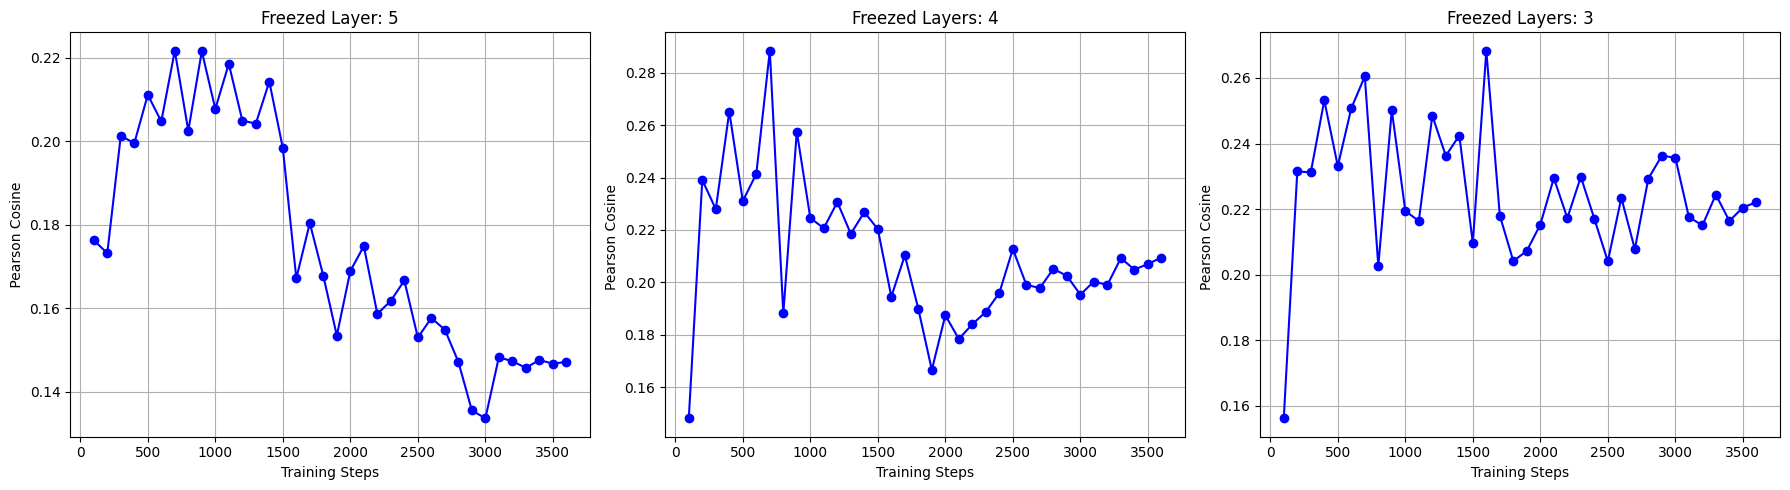

In [ ]:
import matplotlib.pyplot as plt

# Create a 1-row, 3-column layout
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for Top 1 Layer
axs[0].plot(steps, top1_cosine, label='Cosine Similarity', color='blue', linestyle='-', marker='o')
axs[0].set_title('Freezed Layer: 5')
axs[0].set_xlabel('Training Steps')
axs[0].set_ylabel(' Pearson Cosine ')
axs[0].grid(True)

# Plot for Top 2 Layers
axs[1].plot(steps, top2_cosine, label='Cosine Similarity', color='blue', linestyle='-', marker='o')
axs[1].set_title('Freezed Layers: 4')
axs[1].set_xlabel('Training Steps')
axs[1].set_ylabel('Pearson Cosine ')
axs[1].grid(True)

# Plot for Top 3 Layers
axs[2].plot(steps, top3_cosine, label='Cosine Similarity', color='blue', linestyle='-', marker='o')
axs[2].set_title('Freezed Layers: 3')
axs[2].set_xlabel('Training Steps')
axs[2].set_ylabel('Pearson Cosine ')
axs[2].grid(True)

plt.tight_layout()
plt.show()
